In [1]:
"""WOrking on CM1 dataset"""

'WOrking on CM1 dataset'

In [1]:
# Loading CM1 folder
import pandas as pd
import os

# Loading folder path
CM1_path = r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM1"
data = []

# Combining all the files in the CM1 folder
for file in os.listdir(CM1_path):
    if file.endswith('.csv'):
        file_path = os.path.join(CM1_path, file)
        df = pd.read_csv(file_path, skiprows=1) # skipping the first row
        # Append to the list of DataFrames
        data.append(df)
# Concatenate all DataFrames into a single DataFrame
combined_CM1_data = pd.concat(data, ignore_index=True)

print(combined_CM1_data.head(5))
print("Rows & columns:", combined_CM1_data.shape)


   #Point  X(Thompsons)    Y(Counts)
0       0          40.0    46.235340
1       1          40.9    58.811787
2       2          41.0   617.287781
3       3          41.2    62.857056
4       4          42.1  3057.952637
Rows & columns: (92310, 3)


In [2]:
# Preprocessing Data

# summary of the datset
print("Summary :")
summary = combined_CM1_data.describe()
print(summary)

# Cheking for missing values
print("")
print("Cheking for missing values :")
is_null = combined_CM1_data.isnull().sum()
print(is_null)

# dropping "#Point" column as it is not relevant
print("")
print("After droping '#Point' column :")
combined_CM1_data = combined_CM1_data.drop('#Point', axis= 1)
print(combined_CM1_data.head(5))

# Rounding up the values of X(Thompsons) column
print("")
print("After Rounding :")
import numpy as np
combined_CM1_data['X(Thompsons)'] = np.ceil(combined_CM1_data['X(Thompsons)'])
print(combined_CM1_data.head(5))

# Adding features
import numpy as np
from scipy.spatial.distance import cosine

# Adding cosine similarity as a new feature
print("\nCalculating Cosine Similarity...")

# Create a reference vector using the mean of both columns
reference_vector = [
    combined_CM1_data['X(Thompsons)'].mean(),
    combined_CM1_data['Y(Counts)'].mean()
]

# Calculate cosine similarity between each row and the reference vector
combined_CM1_data['cosine_similarity'] = combined_CM1_data.apply(
    lambda row: 1 - cosine([row['X(Thompsons)'], row['Y(Counts)']], reference_vector),
    axis=1
)

# Display the DataFrame with the new feature
print("\nAfter adding cosine similarity:")
print(combined_CM1_data.head())

# 2. Area Ratio: Area ratio using trapezoidal rule with respect to X(Thompsons)
#print("\nCalculating Area Ratio...")
#combined_CM1_data['area_ratio'] = combined_CM1_data['Y(Counts)'] / combined_CM1_data['Y(Counts)'].sum()

# 3. Standard Deviation Ratio: Standard deviation ratio between Y(Counts) and X(Thompsons)
#print("\nCalculating Standard Deviation Ratio...")
#combined_CM1_data['std_ratio'] = combined_CM1_data['Y(Counts)'] / (combined_CM1_data['X(Thompsons)'].std() + 1)  # +1 to avoid division by zero

# Display the DataFrame with the new feature
print("\nAfter adding new features:")
print(combined_CM1_data.head())
# Normalizing the dataset
print("")
print("After Normalization :")
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
columns_to_normalize = ['X(Thompsons)', 'Y(Counts)', 'cosine_similarity']
combined_CM1_data[columns_to_normalize] = scaler.fit_transform(combined_CM1_data[columns_to_normalize])
print(combined_CM1_data.head(5))

Summary :
             #Point  X(Thompsons)      Y(Counts)
count  92310.000000  92310.000000   92310.000000
mean     171.147308    143.243818    1193.070302
std      107.140743     68.833009    9722.745794
min        0.000000     39.900000       0.003136
25%       82.000000     88.200000      22.855255
50%      164.000000    134.000000      70.941631
75%      248.000000    186.100000     283.324089
max      521.000000    413.200000  654898.562500

Cheking for missing values :
#Point          0
X(Thompsons)    0
Y(Counts)       0
dtype: int64

After droping '#Point' column :
   X(Thompsons)    Y(Counts)
0          40.0    46.235340
1          40.9    58.811787
2          41.0   617.287781
3          41.2    62.857056
4          42.1  3057.952637

After Rounding :
   X(Thompsons)    Y(Counts)
0          40.0    46.235340
1          41.0    58.811787
2          41.0   617.287781
3          42.0    62.857056
4          43.0  3057.952637

Calculating Cosine Similarity...

After adding cosin

[LightGBM] [Info] Number of positive: 27633, number of negative: 27753
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 55386, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498917 -> initscore=-0.004333
[LightGBM] [Info] Start training from score -0.004333
Accuracy: 0.9972646517170404
              precision    recall  f1-score   support

Below Median       1.00      1.00      1.00     18402
Above Median       1.00      1.00      1.00     18522

    accuracy                           1.00     36924
   macro avg       1.00      1.00      1.00     36924
weighted avg       1.00      1.00      1.00     36924



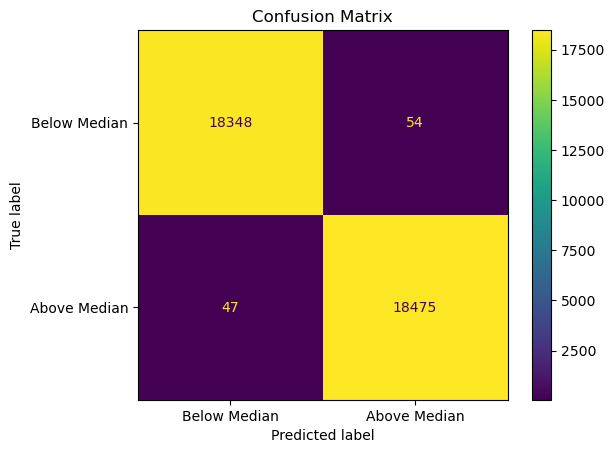

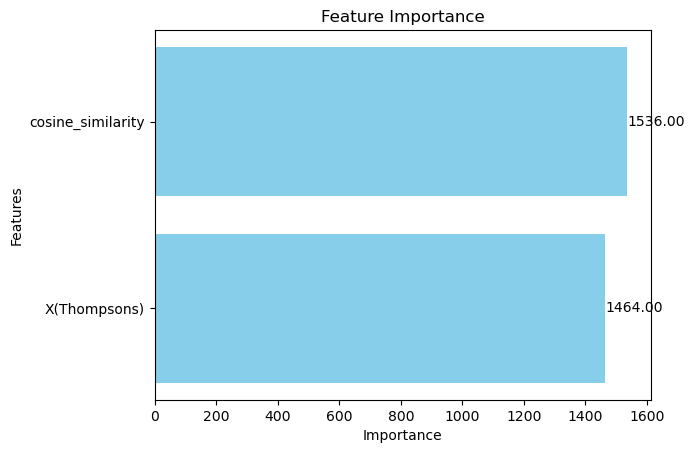

In [3]:
# lightBGM on CM1
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Split dataset into features and target
X = combined_CM1_data[['X(Thompsons)', 'cosine_similarity']]
# Convert Y(Counts) into binary labels based on the median
y = (combined_CM1_data['Y(Counts)'] > combined_CM1_data['Y(Counts)'].median()).astype(int)
#y = combined_CM1_data['Y(Counts)']  # Target: Y(Counts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=50)

# Initialize LightGBM classifier
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=["Below Median", "Above Median"])
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Below Median", "Above Median"])
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = model.feature_importances_
features = X.columns
plt.barh(features, feature_importances, color='skyblue')
for i, v in enumerate(feature_importances):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
# Convert Y(Counts) into categories
"""import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

bins = [0, 100, 1000, float('inf')]  # Define ranges for bins (adjust as needed)
labels = ['Low', 'Medium', 'High']  # Define labels for bins
combined_CM1_data['Y(Counts)_category'] = pd.cut(combined_CM1_data['Y(Counts)'], bins=bins, labels=labels)
print(combined_CM1_data.head())

# Use the new categorical target for classification
X = combined_CM1_data[['X(Thompsons)']]  # Feature: X(Thompsons)
y = combined_CM1_data['Y(Counts)_category']  # Target: Y(Counts) as categories

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50)

# Initialize LightGBM Classifier
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")"""


In [ ]:
"""WOrking on CM2 dataset"""

In [4]:
# Loading CM2 folder
import pandas as pd
import os

# Loading folder path
CM2_path = r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM2"
data = []

# Combining all the files in the CM2 folder
for file in os.listdir(CM2_path):
    if file.endswith('.csv'):
        file_path = os.path.join(CM2_path, file)
        df = pd.read_csv(file_path, skiprows=1) # skipping the first row
        # Append to the list of DataFrames
        data.append(df)
# Concatenate all DataFrames into a single DataFrame
combined_CM2_data = pd.concat(data, ignore_index=True)

print(combined_CM2_data.head(5))
print("Rows & columns:", combined_CM2_data.shape)

   #Point  X(Thompsons)    Y(Counts)
0       0          41.0  6331.916016
1       1          42.0  1271.348389
2       2          43.0  1042.080078
3       3          44.0  1405.044189
4       4          44.9    39.250080
Rows & columns: (53219, 3)


In [5]:
# Preprocessing Data

# summary of the datset
print("Summary :")
summary = combined_CM2_data.describe()
print(summary)

# Cheking for missing values
print("")
print("Cheking for missing values :")
is_null = combined_CM2_data.isnull().sum()
print(is_null)

# dropping "#Point" column as it is not relevant
print("")
print("After droping '#Point' column :")
combined_CM2_data = combined_CM2_data.drop('#Point', axis= 1)
print(combined_CM2_data.head(5))

# Rounding up the values of X(Thompsons) column
print("")
print("After Rounding :")
import numpy as np
combined_CM2_data['X(Thompsons)'] = np.ceil(combined_CM2_data['X(Thompsons)'])
print(combined_CM2_data.head(5))

# Adding features
import numpy as np
from scipy.spatial.distance import cosine

# Adding cosine similarity as a new feature
print("\nCalculating Cosine Similarity...")

# Create a reference vector using the mean of both columns
reference_vector = [
    combined_CM2_data['X(Thompsons)'].mean(),
    combined_CM2_data['Y(Counts)'].mean()
]

# Calculate cosine similarity between each row and the reference vector
combined_CM2_data['cosine_similarity'] = combined_CM2_data.apply(
    lambda row: 1 - cosine([row['X(Thompsons)'], row['Y(Counts)']], reference_vector),
    axis=1
)

# Display the DataFrame with the new feature
print("\nAfter adding cosine similarity:")
print(combined_CM2_data.head())

# 2. Area Ratio: Area ratio using trapezoidal rule with respect to X(Thompsons)
#print("\nCalculating Area Ratio...")
#combined_CM2_data['area_ratio'] = combined_CM2_data['Y(Counts)'] / combined_CM2_data['Y(Counts)'].sum()

# 3. Standard Deviation Ratio: Standard deviation ratio between Y(Counts) and X(Thompsons)
#print("\nCalculating Standard Deviation Ratio...")
#combined_CM2_data['std_ratio'] = combined_CM2_data['Y(Counts)'] / (combined_CM2_data['X(Thompsons)'].std() + 1)  # +1 to avoid division by zero

# Display the DataFrame with the new feature
print("\nAfter adding new features:")
print(combined_CM2_data.head())
# Normalizing the dataset
print("")
print("After Normalization :")
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
columns_to_normalize = ['X(Thompsons)', 'Y(Counts)', 'cosine_similarity']
combined_CM2_data[columns_to_normalize] = scaler.fit_transform(combined_CM2_data[columns_to_normalize])
print(combined_CM2_data.head(5))

Summary :
             #Point  X(Thompsons)     Y(Counts)
count  53219.000000  53219.000000  5.321900e+04
mean      50.871305    109.085851  2.825648e+03
std       33.767862     49.360225  2.200343e+04
min        0.000000     40.000000  1.060486e-01
25%       22.000000     70.000000  6.670188e+01
50%       47.000000    100.900000  2.327066e+02
75%       75.000000    140.000000  8.122075e+02
max      156.000000    503.200000  1.066836e+06

Cheking for missing values :
#Point          0
X(Thompsons)    0
Y(Counts)       0
dtype: int64

After droping '#Point' column :
   X(Thompsons)    Y(Counts)
0          41.0  6331.916016
1          42.0  1271.348389
2          43.0  1042.080078
3          44.0  1405.044189
4          44.9    39.250080

After Rounding :
   X(Thompsons)    Y(Counts)
0          41.0  6331.916016
1          42.0  1271.348389
2          43.0  1042.080078
3          44.0  1405.044189
4          45.0    39.250080

Calculating Cosine Similarity...

After adding cosine similar

[LightGBM] [Info] Number of positive: 15869, number of negative: 16062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 486
[LightGBM] [Info] Number of data points in the train set: 31931, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496978 -> initscore=-0.012089
[LightGBM] [Info] Start training from score -0.012089
Accuracy: 0.9972754603532507
              precision    recall  f1-score   support

Below Median       1.00      1.00      1.00     10548
Above Median       1.00      1.00      1.00     10740

    accuracy                           1.00     21288
   macro avg       1.00      1.00      1.00     21288
weighted avg       1.00      1.00      1.00     21288



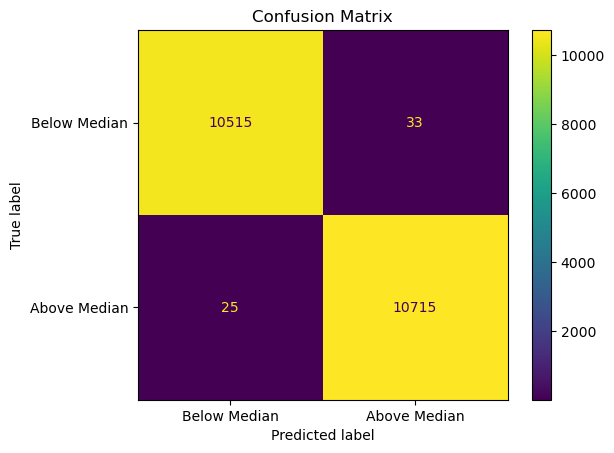

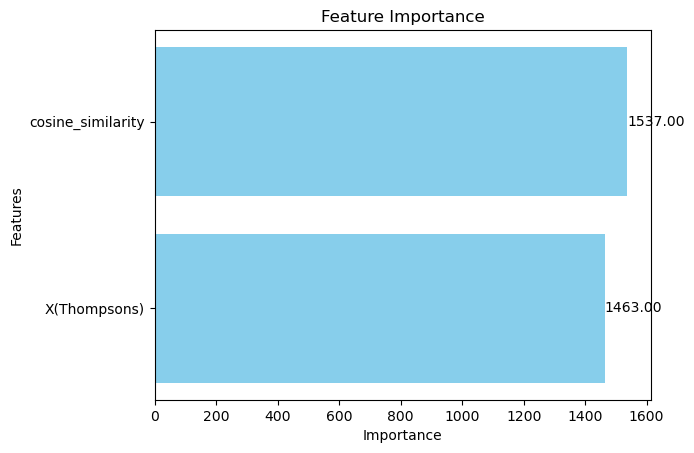

In [6]:
# lightBGM on CM2
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Split dataset into features and target
X = combined_CM2_data[['X(Thompsons)', 'cosine_similarity']]
# Convert Y(Counts) into binary labels based on the median
y = (combined_CM2_data['Y(Counts)'] > combined_CM2_data['Y(Counts)'].median()).astype(int)
#y = combined_CM1_data['Y(Counts)']  # Target: Y(Counts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=50)

# Initialize LightGBM classifier
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=["Below Median", "Above Median"])
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Below Median", "Above Median"])
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = model.feature_importances_
features = X.columns
plt.barh(features, feature_importances, color='skyblue')
for i, v in enumerate(feature_importances):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
"""WOrking on CM3 dataset"""

In [7]:
# Loading CM3 folder
import pandas as pd
import os

# Loading folder path
CM3_path = r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM3"
data = []

# Combining all the files in the CM3 folder
for file in os.listdir(CM3_path):
    if file.endswith('.csv'):
        file_path = os.path.join(CM3_path, file)
        df = pd.read_csv(file_path, skiprows=1) # skipping the first row
        # Append to the list of DataFrames
        data.append(df)
# Concatenate all DataFrames into a single DataFrame
combined_CM3_data = pd.concat(data, ignore_index=True)

print(combined_CM3_data.head(5))
print("Rows & columns:", combined_CM3_data.shape)

   #Point  X(Thompsons)    Y(Counts)
0       0       40.1033   329.851929
1       1       41.0653  8048.045898
2       2       42.0960  1061.551270
3       3       43.0745  7670.504395
4       4       44.0018   879.785889
Rows & columns: (301237, 3)


In [8]:
# Preprocessing Data

# summary of the datset
print("Summary :")
summary = combined_CM3_data.describe()
print(summary)

# Cheking for missing values
print("")
print("Cheking for missing values :")
is_null = combined_CM3_data.isnull().sum()
print(is_null)

# dropping "#Point" column as it is not relevant
print("")
print("After droping '#Point' column :")
combined_CM3_data = combined_CM3_data.drop('#Point', axis= 1)
print(combined_CM3_data.head(5))

# Rounding up the values of X(Thompsons) column
print("")
print("After Rounding :")
import numpy as np
combined_CM3_data['X(Thompsons)'] = np.ceil(combined_CM3_data['X(Thompsons)'])
print(combined_CM3_data.head(5))

# Adding features
import numpy as np
from scipy.spatial.distance import cosine

# Adding cosine similarity as a new feature
print("\nCalculating Cosine Similarity...")

# Create a reference vector using the mean of both columns
reference_vector = [
    combined_CM3_data['X(Thompsons)'].mean(),
    combined_CM3_data['Y(Counts)'].mean()
]

# Calculate cosine similarity between each row and the reference vector
combined_CM3_data['cosine_similarity'] = combined_CM3_data.apply(
    lambda row: 1 - cosine([row['X(Thompsons)'], row['Y(Counts)']], reference_vector),
    axis=1
)

# Display the DataFrame with the new feature
print("\nAfter adding cosine similarity:")
print(combined_CM3_data.head())

# 2. Area Ratio: Area ratio using trapezoidal rule with respect to X(Thompsons)
#print("\nCalculating Area Ratio...")
#combined_CM3_data['area_ratio'] = combined_CM3_data['Y(Counts)'] / combined_CM3_data['Y(Counts)'].sum()

# 3. Standard Deviation Ratio: Standard deviation ratio between Y(Counts) and X(Thompsons)
#print("\nCalculating Standard Deviation Ratio...")
#combined_CM3_data['std_ratio'] = combined_CM3_data['Y(Counts)'] / (combined_CM3_data['X(Thompsons)'].std() + 1)  # +1 to avoid division by zero

# Display the DataFrame with the new feature
print("\nAfter adding new features:")
print(combined_CM3_data.head())
# Normalizing the dataset
print("")
print("After Normalization :")
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
columns_to_normalize = ['X(Thompsons)', 'Y(Counts)', 'cosine_similarity']
combined_CM3_data[columns_to_normalize] = scaler.fit_transform(combined_CM3_data[columns_to_normalize])
print(combined_CM3_data.head(5))

Summary :
              #Point   X(Thompsons)     Y(Counts)
count  301237.000000  301237.000000  3.012370e+05
mean      312.453932     201.252276  2.618394e+03
std       187.777707      92.004717  2.747994e+04
min         0.000000      39.900000  3.356934e-04
25%       153.000000     121.800000  3.052767e+01
50%       307.000000     198.970000  9.655919e+01
75%       461.000000     276.500000  3.923847e+02
max       933.000000     546.020000  1.820741e+06

Cheking for missing values :
#Point          0
X(Thompsons)    0
Y(Counts)       0
dtype: int64

After droping '#Point' column :
   X(Thompsons)    Y(Counts)
0       40.1033   329.851929
1       41.0653  8048.045898
2       42.0960  1061.551270
3       43.0745  7670.504395
4       44.0018   879.785889

After Rounding :
   X(Thompsons)    Y(Counts)
0          41.0   329.851929
1          42.0  8048.045898
2          43.0  1061.551270
3          44.0  7670.504395
4          45.0   879.785889

Calculating Cosine Similarity...

After add

[LightGBM] [Info] Number of positive: 90355, number of negative: 90387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 180742, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499911 -> initscore=-0.000354
[LightGBM] [Info] Start training from score -0.000354
Accuracy: 0.9981161044026723
              precision    recall  f1-score   support

Below Median       1.00      1.00      1.00     60232
Above Median       1.00      1.00      1.00     60263

    accuracy                           1.00    120495
   macro avg       1.00      1.00      1.00    120495
weighted avg       1.00      1.00      1.00    120495



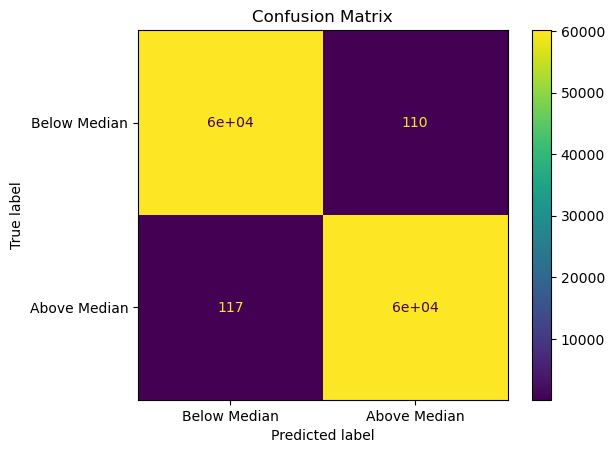

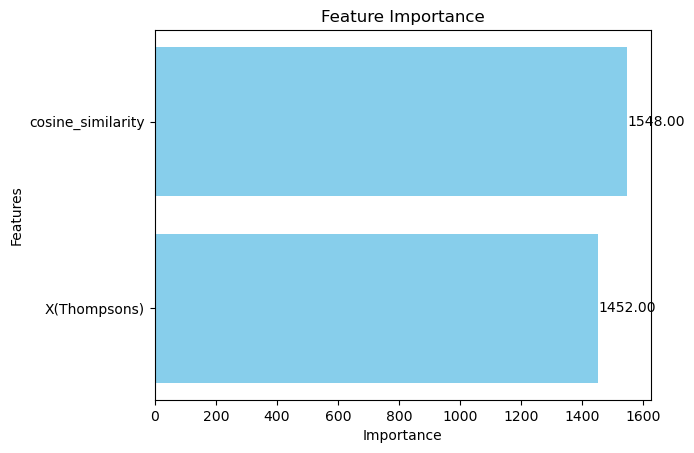

In [9]:
# lightBGM on CM3
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Split dataset into features and target
X = combined_CM3_data[['X(Thompsons)', 'cosine_similarity']]
# Convert Y(Counts) into binary labels based on the median
y = (combined_CM3_data['Y(Counts)'] > combined_CM3_data['Y(Counts)'].median()).astype(int)
#y = combined_CM3_data['Y(Counts)']  # Target: Y(Counts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=50)

# Initialize LightGBM classifier
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=["Below Median", "Above Median"])
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Below Median", "Above Median"])
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = model.feature_importances_
features = X.columns
plt.barh(features, feature_importances, color='skyblue')
for i, v in enumerate(feature_importances):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
"""WOrking on CM1,CM2,CM3 combined"""

In [10]:
# Loading CM1, CM2 and CM3 folder combined
import pandas as pd
import os

# Loading folder paths
CM123_paths = [
    r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM1",
    r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM2",
    r"C:\Local Disk (A)\Github Files\Projects\Mass-Sceptra-Classification\Datasets\CM3"
]

data = []

# Combining all the files in CM1, CM2, and CM3 folders
for folder_path in CM123_paths:
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path, skiprows=1)  # skipping the first row
            # Append to the list of DataFrames
            data.append(df)

# Concatenate all DataFrames into a single DataFrame
combined_CM123_data = pd.concat(data, ignore_index=True)

# Display the combined data
print(combined_CM123_data.head(5))
print("Rows & columns:", combined_CM123_data.shape)


   #Point  X(Thompsons)    Y(Counts)
0       0          40.0    46.235340
1       1          40.9    58.811787
2       2          41.0   617.287781
3       3          41.2    62.857056
4       4          42.1  3057.952637
Rows & columns: (446766, 3)


In [ ]:
# Preprocessing Data

# summary of the datset
print("Summary :")
summary = combined_CM123_data.describe()
print(summary)

# Cheking for missing values
print("")
print("Cheking for missing values :")
is_null = combined_CM123_data.isnull().sum()
print(is_null)

# dropping "#Point" column as it is not relevant
print("")
print("After droping '#Point' column :")
combined_CM123_data = combined_CM123_data.drop('#Point', axis= 1)
print(combined_CM123_data.head(5))

# Rounding up the values of X(Thompsons) column
print("")
print("After Rounding :")
import numpy as np
combined_CM123_data['X(Thompsons)'] = np.ceil(combined_CM123_data['X(Thompsons)'])
print(combined_CM123_data.head(5))

# Adding features
import numpy as np
from scipy.spatial.distance import cosine

# Adding cosine similarity as a new feature
print("\nCalculating Cosine Similarity...")

# Create a reference vector using the mean of both columns
reference_vector = [
    combined_CM123_data['X(Thompsons)'].mean(),
    combined_CM123_data['Y(Counts)'].mean()
]

# Calculate cosine similarity between each row and the reference vector
combined_CM123_data['cosine_similarity'] = combined_CM123_data.apply(
    lambda row: 1 - cosine([row['X(Thompsons)'], row['Y(Counts)']], reference_vector),
    axis=1
)

# Display the DataFrame with the new feature
print("\nAfter adding cosine similarity:")
print(combined_CM123_data.head())

# 2. Area Ratio: Area ratio using trapezoidal rule with respect to X(Thompsons)
#print("\nCalculating Area Ratio...")
#combined_CM123_data['area_ratio'] = combined_CM123_data['Y(Counts)'] / combined_CM123_data['Y(Counts)'].sum()

# 3. Standard Deviation Ratio: Standard deviation ratio between Y(Counts) and X(Thompsons)
#print("\nCalculating Standard Deviation Ratio...")
#combined_CM123_data['std_ratio'] = combined_CM123_data['Y(Counts)'] / (combined_CM123_data['X(Thompsons)'].std() + 1)  # +1 to avoid division by zero

# Display the DataFrame with the new feature
print("\nAfter adding new features:")
print(combined_CM123_data.head())
# Normalizing the dataset
print("")
print("After Normalization :")
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

scaler = MinMaxScaler()
columns_to_normalize = ['X(Thompsons)', 'Y(Counts)', 'cosine_similarity']
combined_CM123_data[columns_to_normalize] = scaler.fit_transform(combined_CM123_data[columns_to_normalize])
print(combined_CM123_data.head(5))

Summary :
              #Point   X(Thompsons)     Y(Counts)
count  446766.000000  446766.000000  4.467660e+05
mean      252.097548     178.287758  2.348584e+03
std       186.858271      90.313249  2.422233e+04
min         0.000000      39.900000  3.356934e-04
25%        87.000000     102.000000  3.061439e+01
50%       220.000000     165.000000  1.007740e+02
75%       392.000000     248.900000  4.151892e+02
max       933.000000     546.020000  1.820741e+06

Cheking for missing values :
#Point          0
X(Thompsons)    0
Y(Counts)       0
dtype: int64

After droping '#Point' column :
   X(Thompsons)    Y(Counts)
0          40.0    46.235340
1          40.9    58.811787
2          41.0   617.287781
3          41.2    62.857056
4          42.1  3057.952637

After Rounding :
   X(Thompsons)    Y(Counts)
0          40.0    46.235340
1          41.0    58.811787
2          41.0   617.287781
3          42.0    62.857056
4          43.0  3057.952637

Calculating Cosine Similarity...

After add

[LightGBM] [Info] Number of positive: 133709, number of negative: 134350
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 268059, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498804 -> initscore=-0.004783
[LightGBM] [Info] Start training from score -0.004783
Accuracy: 0.9983380617435244
              precision    recall  f1-score   support

Below Median       1.00      1.00      1.00     89033
Above Median       1.00      1.00      1.00     89674

    accuracy                           1.00    178707
   macro avg       1.00      1.00      1.00    178707
weighted avg       1.00      1.00      1.00    178707



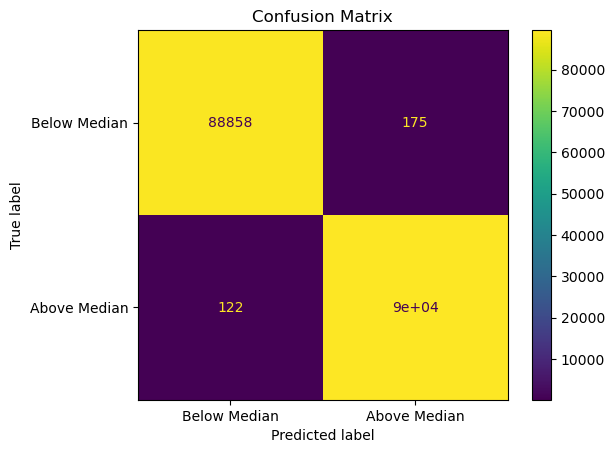

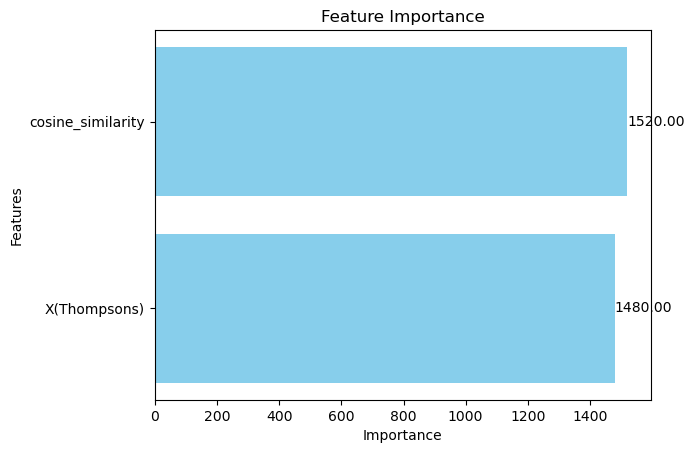

In [12]:
# lightBGM on CM1, CM2 & CM3 combined
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Split dataset into features and target
X = combined_CM123_data[['X(Thompsons)', 'cosine_similarity']]
# Convert Y(Counts) into binary labels based on the median
y = (combined_CM123_data['Y(Counts)'] > combined_CM123_data['Y(Counts)'].median()).astype(int)
#y = combined_CM123_data['Y(Counts)']  # Target: Y(Counts)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=50)

# Initialize LightGBM classifier
model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, n_estimators=100)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:}")

# Classification Report
report = classification_report(y_test, y_pred, target_names=["Below Median", "Above Median"])
print(report)

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=["Below Median", "Above Median"])
plt.title("Confusion Matrix")
plt.show()

# Feature Importance
feature_importances = model.feature_importances_
features = X.columns
plt.barh(features, feature_importances, color='skyblue')
for i, v in enumerate(feature_importances):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()